In [1]:
import tensorflow as tf
from tensorflow.contrib.layers import xavier_initializer
import numpy as np
from distributions import *

from matplotlib import pyplot as plt
%matplotlib inline

Generator and discriminator parameter initializers

In [2]:
def make_gen(n_input = 100, n_hidden_1 = 300, n_hidden_2 = 300, n_out = 2,
             random_seed = None):
    #Initializer
    xavier_init = xavier_initializer(seed = random_seed)
    
    # Network Parameters
    gen_params = {}
    gen_params['n_input'] = n_input
    gen_params['n_hidden_1'] = n_hidden_1 # 1st layer number of features
    gen_params['n_hidden_2'] = n_hidden_2 # 2nd layer number of features
    gen_params['n_out'] = n_out

    # Store layers weight & bias
    gen_params['weights'] = {
        'w1': tf.Variable(xavier_init([n_input, n_hidden_1]), name = 'g_w1'),
        'w2': tf.Variable(xavier_init([n_hidden_1, n_hidden_2]), name = 'g_w2'),
        'w_out': tf.Variable(xavier_init([n_hidden_2, n_out]), name = 'g_w_out')
    }
    gen_params['biases'] = {
        'b1': tf.Variable(tf.zeros([n_hidden_1]), name = 'g_b1'),
        'b2': tf.Variable(tf.zeros([n_hidden_2]), name = 'g_b1'),
        'b_out': tf.Variable(tf.zeros([n_out]), name = 'g_b_out')
    }
    
    #return parameter dict
    return(gen_params)

def make_disc(n_input = 2, n_hidden_1 = 300, n_hidden_2 = 300,
             random_seed = None):
    #Initializer
    xavier_init = xavier_initializer(seed = random_seed)
    
    # Network Parameters
    disc_params = {}
    disc_params['n_input'] = n_input
    disc_params['n_hidden_1'] = n_hidden_1 # 1st layer number of features
    disc_params['n_hidden_2'] = n_hidden_2 # 2nd layer number of features

    # Store layers weight & bias
    disc_params['weights'] = {
        'w1': tf.Variable(xavier_init([n_input, n_hidden_1]), name = 'd_w1'),
        'w2': tf.Variable(xavier_init([n_hidden_1, n_hidden_2]), name = 'd_w2'),
        'w_out': tf.Variable(xavier_init([n_hidden_2, 1]), name = 'd_w_out')
    }
    disc_params['biases'] = {
        'b1': tf.Variable(tf.zeros([n_hidden_1]), name = 'd_b1'),
        'b2': tf.Variable(tf.zeros([n_hidden_2]), name = 'd_b1'),
        'b_out': tf.Variable(tf.zeros([1]), name = 'd_b_out')
    }
    
    #return parameter dict
    return(disc_params)

GAN model

In [9]:
class GAN(object):
    def __init__(self, in_dist, gen_params = None, disc_params = None,
                 data_dim = 2, 
                 gen_hidden_1 = 300, gen_hidden_2 = 300,
                 disc_hidden_1 = 300, disc_hidden_2 = 300,
                 random_seed = None):
        
        self.in_dist = in_dist
        z_dim = in_dist.len
        self.z_dim = z_dim
        
        #Generator params, may pass optional initialization
        gen_params = gen_params if gen_params is not None else make_gen(
            n_input = z_dim, n_hidden_1 = gen_hidden_1, n_hidden_2 = gen_hidden_2, n_out = data_dim, 
            random_seed = random_seed
        )
        self.gen_params = gen_params
        
        z_dim = gen_params['n_input']
        self.z_dim = z_dim
        g_theta = [theta for theta in gen_params['weights'].values()] + \
                  [theta for theta in gen_params['biases'].values()]
        self.g_theta = g_theta
            
        #Discriminator params, may pass optional initialization
        disc_params = disc_params if disc_params is not None else make_disc(
            n_input = data_dim, n_hidden_1 = disc_hidden_1, n_hidden_2 = disc_hidden_2,
            random_seed = random_seed
        )
        self.disc_params = disc_params
        
        x_dim = disc_params['n_input']
        d_theta = [theta for theta in disc_params['weights'].values()] + \
                  [theta for theta in disc_params['biases'].values()]
        self.d_theta = d_theta
            
        #GAN graph
        X = tf.placeholder(tf.float32, shape=[None, x_dim], name='X')
        self.X = X
        Z = tf.placeholder(tf.float32, shape=[None, z_dim], name='Z')
        self.Z = Z
        
        G_X = self.gen(Z)
        
        D_logit_real, D_real = self.disc(X)
        self.D_real = D_real
        
        D_logit_fake, D_fake = self.disc(G_X)
        self.D_fake = D_fake

    #Generator and discriminator models
    def gen(self, z):
        #Params
        weights = self.gen_params['weights']
        biases = self.gen_params['biases']
        
        #Graph
        g_h1 = tf.nn.relu(tf.matmul(z, weights['w1']) + biases['b1'])
        g_h2 = tf.nn.relu(tf.matmul(g_h1, weights['w2']) + biases['b2'])
        # Output layer with linear activation
        g_out = tf.matmul(g_h2, weights['w_out']) + biases['b_out']
        
        return(g_out)
    
    def disc(self, x):
        #Params
        weights = self.disc_params['weights']
        biases = self.disc_params['biases']
        
        #Graph
        d_h1 = tf.nn.relu(tf.matmul(x, weights['w1']) + biases['b1'])
        d_h2 = tf.nn.relu(tf.matmul(d_h1, weights['w2']) + biases['b2'])
        # Logit
        d_logit = tf.matmul(d_h2, weights['w_out']) + biases['b_out']
        #Probability
        d_prob = tf.nn.sigmoid(d_logit)
        
        return(d_logit, d_prob)
    
    def sample_Z(self, m):
        return self.in_dist.sample(m).astype('float32')
    
    def sample_G(self, m):
        return self.gen(self.sample_Z(m))
    
    def train(self, x, learning_rate = 0.001, training_epochs = 300, mb_size = 64, display_step = 30):
        sess = tf.Session()
        self.sess = sess
        
        N = len(x)
        n_batches = N // mb_size
        
        #Losses
        D_loss = -tf.reduce_mean(tf.log(self.D_real) + tf.log(1. - self.D_fake))
        G_loss = -tf.reduce_mean(tf.log(self.D_fake))
        
        #Optimizers
        D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(D_loss, var_list=self.d_theta)
        G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(G_loss, var_list=self.g_theta)
        
        # Initializing the variables
        init = tf.global_variables_initializer()
        
        with sess.as_default():
            sess.run(init)
            neg_d_losses = []
            for epoch in range(training_epochs):
                D_loss_avg = 0
                if epoch % display_step == 0:
                    G_x = self.sample_G(1000).eval()
                    plt.figure()
                    plt.scatter(x[:,0], x[:,1])
                    plt.scatter(G_x[:,0], G_x[:,1])
                    plt.show()
                    
                
                for batch in range(n_batches):
                    X_mb = x[(batch*mb_size):((batch+1)*mb_size), :]

                    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={self.X: X_mb, self.Z: self.sample_Z(mb_size)})
                    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={self.Z: self.sample_Z(mb_size)})
                    
                    D_loss_avg = D_loss_avg + D_loss_curr/n_batches
                neg_d_losses.append(-D_loss_avg)
            
            plt.figure()
            plt.plot(neg_d_losses)
            plt.title("Negative Discriminator Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Negative D_Loss")

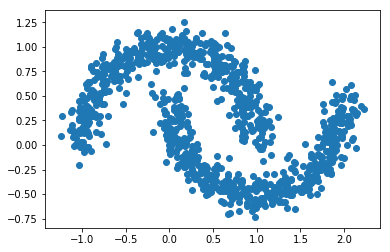

In [10]:
from sklearn.datasets import make_moons
N = 1000
X, Y = make_moons(N, noise = .1)
X = X.astype('float32')
Y = np.array([[1,0] if y else [0,1] for y in Y])

plt.scatter(X[:,0], X[:,1])

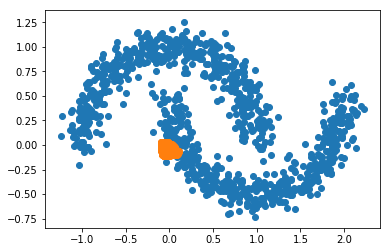

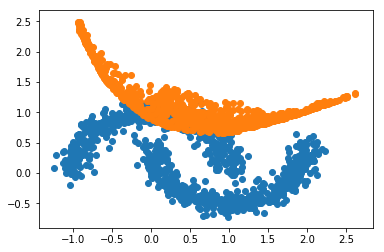

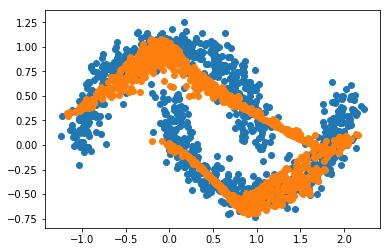

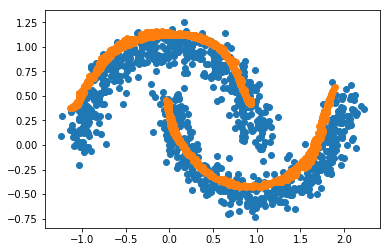

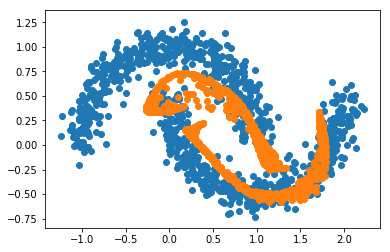

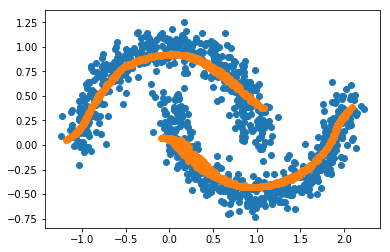

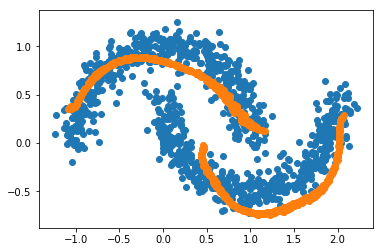

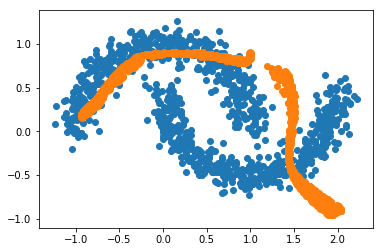

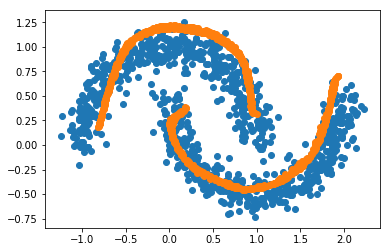

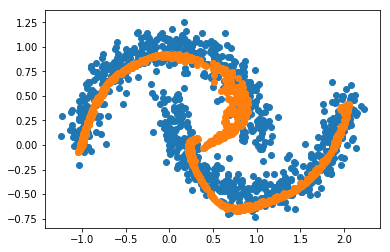

KeyboardInterrupt: 

In [11]:
c = Categorical(2)
u = Uniform()
factor = Factor(c, *[u]*2)

gan = GAN(
    in_dist = factor,
    data_dim = 2, 
    gen_hidden_1 = 300, gen_hidden_2 = 300,
    disc_hidden_1 = 300, disc_hidden_2 = 300,
)
gan.train(X, learning_rate = 0.0001, training_epochs = 5000, mb_size = 100, display_step = 500)

In [ ]:
c1 = 1*np.ones((100, 2))
c1[:,1] = np.random.uniform(-1,1, 100)
c1 = c1.astype('float32')

In [ ]:
g1 = gan.gen(c1).eval(session=gan.sess)
plt.scatter(g1[:,0], g1[:,1])